# Case Study: Neuro

This tutorial of shows how analyze RNA velocity using cellDancer, including:
* model estimation.
* deriving cell fates in embedding level.
* pseudotime estimation.

Here is the case study for the mouse hippocampal dentate gyrus neurogenesis data, we followed the gene and cell filtering methods by [La Manno et al.](https://www.nature.com/articles/s41587-020-0591-3), and selected 18,140 cells with 2,159 genes.

## Import packages

To run the notebook locally, create a conda environment as ```conda env create -n celldancer python==3.7.6```, then install the dependencies by ```pip install -r requirements.txt``` using this [requirememts.txt](requirememts.txt).

In [1]:
%load_ext autoreload
%autoreload 2

# import packages
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

# import from absolute directory
# srcdir = '/Users/pengzhizhang/cellDancer/src'
srcdir = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/src'
# srcdir = '/Users/wanglab/Documents/ShengyuLi/Velocity/bin/celldancer_polish/src'
#srcdir = '/Users/chen.weiqing/Documents/GitHub/cellDancer/src'
sys.path.append(srcdir)

import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
# from celldancer.velocity_estimation import velocity
# from celldancer.compute_cell_velocity import compute
# from celldancer.pseudo_time import pseudo_time
# from celldancer.embedding_kinetic_para import embedding

## Load mouse hippocampal dentate gyrus neurogenesis data

The input data for cellDancer contains the abundances of unspliced RNA and spliced RNA. For the detail of obtaining the dataset and pre-processing, please refer to [Data Preprocessing](http:link).

The data of mouse hippocampal dentate gyrus neurogenesis could be downloaded from [Github](http:xxx/xxx/DentateGyrus_cell_type_u_s.csv). It could be loaded by ```pd.read_csv('your_path/DentateGyrus.csv')```. To load your own data, the dataframe should contain columns 'gene_name', 'unsplice', 'splice' ,'cellID' ,'clusters' ,'embedding1' , and 'embedding2.' For a detailed description of the data structure, please refer to [Data Preprocessing](http:link).

In [2]:
%autoreload 2
cell_type_u_s_path="/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/raw_data/DentateGyrus.csv"
#cell_type_u_s_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/DentateGyrus.csv'
#cell_type_u_s_path='/Users/chen.weiqing/code/celldancer/DentateGyrus.csv'
cell_type_u_s=pd.read_csv(cell_type_u_s_path)
cell_type_u_s

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Rgs20,0.069478,0.021971,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,Rgs20,0.085834,0.016256,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,Rgs20,0.068644,0.047774,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,Rgs20,0.045387,0.018101,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,Rgs20,0.040457,0.012846,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...
39164255,Gpm6b,0.876650,1.276089,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
39164256,Gpm6b,2.024897,5.152006,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
39164257,Gpm6b,1.848051,1.491445,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
39164258,Gpm6b,0.696361,1.189091,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


## Velocity Estimation for Sample Genes

```celldancer.velocity_estimation.velocity()``` could be used to estimate the velocity. 

Here, 30 genes in ```gene_list``` will be estimated as an example. By default, the Deep Neural Network (DNN) will run at most 200 epochs. It will check the loss every 10 epochs. If the loss has no improvement in 3 checked epochs, the epoch will end, and the network at that time will be used for the estimation. If supported by device, parallel computing could be used to improve the speed, ```n_jobs``` could be adjusted according to demand.

After fitting, the predicted unspliced and spliced reads, alpha, beta, and gamma will be added to the original dataframe and returned.

In [3]:
%autoreload 2

# no deleted
gene_list=['Klf7', 'Scn2a1', 'Tmem163', 'Gnao1', 'Grm7', 'Dctn3', 'Plppr4', 'Shisa9', 'Pak3', 'Camk4', 'Evl', 'Slc24a2', 'Atp1a3', 'Dcx', 'Foxk2', 'Slc24a3', 'Gabrg3', 'Slc4a4', 'Prkag2', 'Nrxn1', 'Gpm6b', 'Fads2', 'Anks1b', 'Sfxn5', 'Ppfia2', 'Stxbp6', 'Ank2', 'Rgma', 'Gria1', 'Ablim1', 'Psd3', 'Ntrk2', 'Ncald', 'Abca1', 'Slc1a3', 'Hepacam', 'Spock3', 'Unc80', 'Nsf', 'Rims1', 'Astn1', 'Cdh9', 'Cdh13', 'Map1b', 'Camk2a', 'Dlgap1', 'Syt11', 'Sptbn1', 'Tbc1d16', 'Cadm1', 'Nav1', 'Sphkap', 'Prkcg', 'Ptpro', 'Adam23', 'Raver2', 'Pcsk2', 'Sez6l', 'Diaph3', 'Adgrb3', 'Kcnip1', 'Ppp3ca']
# kept 20
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Stxbp6', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Camk2a', 'Evl','Tbc1d16', 'Cadm1', 'Kcnip1', 'Ptpro', 'Sez6l', 'Diaph3',]
# kept 15
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Ptpro', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Evl','Tbc1d16', 'Cadm1']
# 30
gene_list=['Psd3', 'Dcx', 'Syt11', 'Diaph3', 'Slc1a3', 'Gria1', 'Dctn3', 'Map1b', 'Camk2a', 'Gpm6b', 'Sez6l', 'Evl', 'Astn1', 'Ank2', 'Klf7', 'Tbc1d16', 'Atp1a3', 'Stxbp6', 'Scn2a1', 'Lhx9', 'Slc4a4', 'Ppfia2', 'Kcnip1', 'Ptpro', 'Ntrk2', 'Gnao1', 'Cadm1', 'Mef2c', 'Sptbn1', 'Ncald']

loss_df, cellDancer_df=cd.velocity_estimation.velocity(cell_type_u_s,\
                                                       gene_list=gene_list,\
                                                       permutation_ratio=0.1,\
                                                       norm_u_s=False,\
                                                       norm_cell_distribution=False)
cellDancer_df

Using /Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/analysis/CaseStudyNotebook/cell_dancer_velocity_2022-06-01 11-23-45 as the output path.
Arranging genes for parallel job.
30  genes were arranged to  1  portion.


Velocity Estimation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:20<00:00, 140.89s/it]


,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,Klf7,0.408467,1.294797,0.444935,1.475828,0.454905,0.935128,0.015373,0.077489,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429
1,1,Klf7,0.379136,1.256870,0.411796,1.424216,0.419835,0.935061,0.015772,0.077489,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895
2,2,Klf7,0.893599,3.395004,0.969404,3.832591,1.033540,0.986942,0.001990,0.077489,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419
3,3,Klf7,0.640505,2.739187,0.669036,3.047821,0.684626,0.979797,0.003759,0.077489,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485
4,4,Klf7,0.662303,2.433943,0.712970,2.749427,0.745024,0.971894,0.005226,0.077489,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544195,18135,Kcnip1,0.018745,0.005679,0.243844,0.008779,0.463909,0.731405,1.322285,0.079982,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668
544196,18136,Kcnip1,0.148039,0.093618,0.380534,0.085685,0.572677,0.727422,1.319759,0.079982,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788
544197,18137,Kcnip1,0.080708,0.032079,0.312729,0.040230,0.522807,0.728119,1.323665,0.079982,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364
544198,18138,Kcnip1,0.078976,0.033418,0.310343,0.040067,0.520257,0.728360,1.323348,0.079982,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549


## Visualization of sample genes' prediction

Let’s visualize the predicted results pf each gene with ```celldancer.cdplt.gene.scatter_gene()```

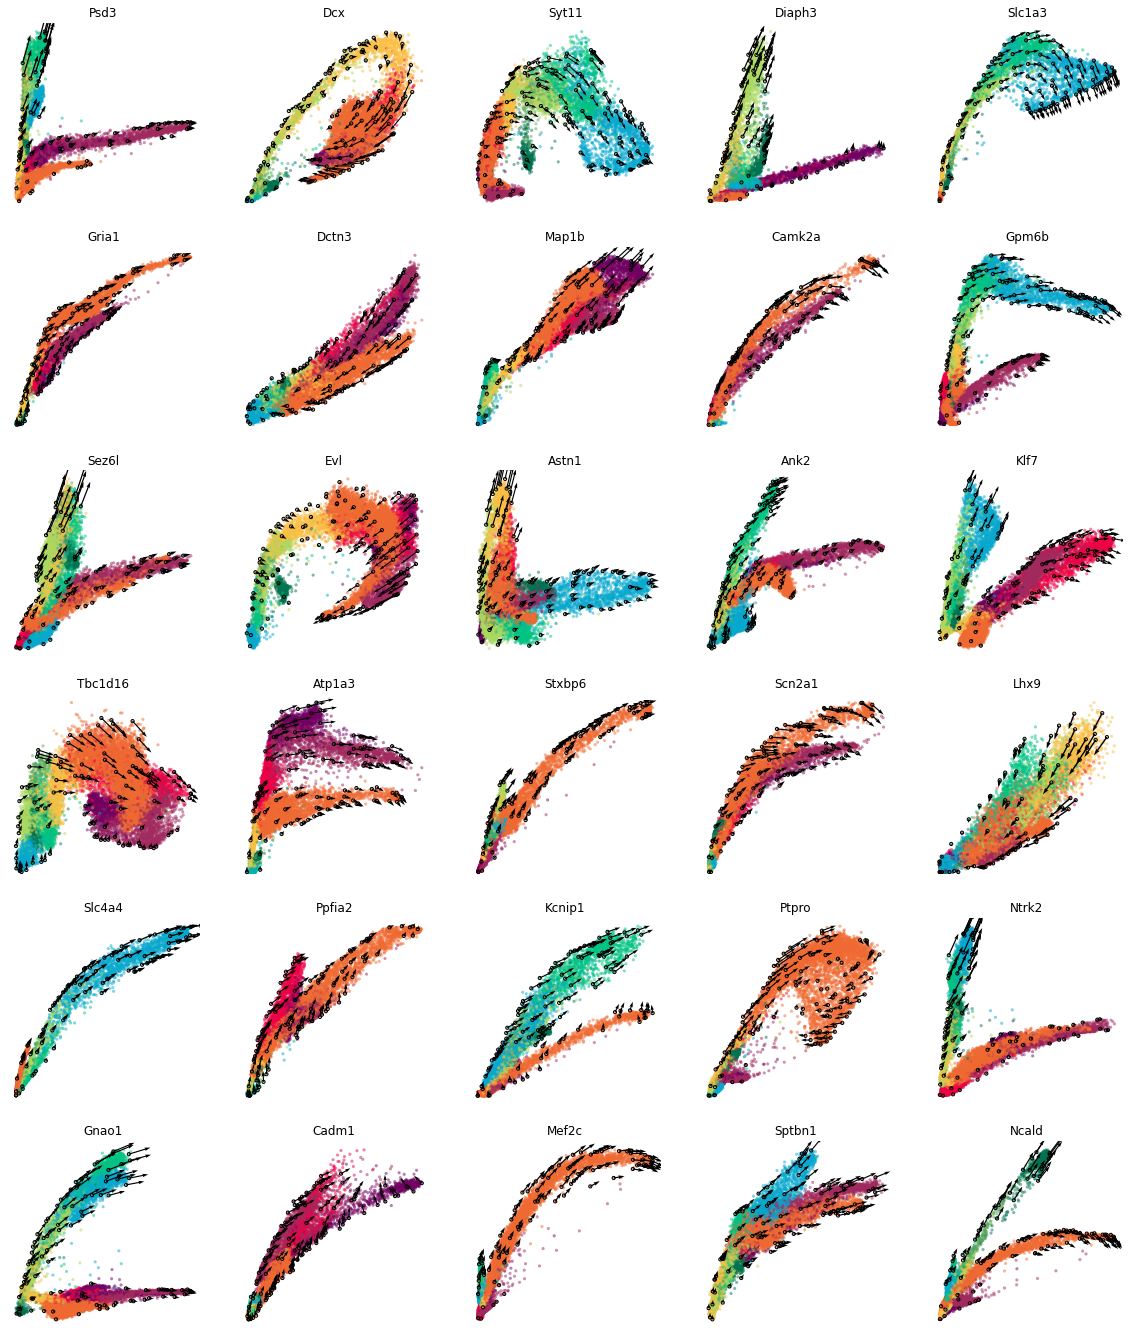

In [4]:
%autoreload 2

ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 10,
        velocity=True,
        gene=gene_list[i])
    
    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

## Load the velocity estimation result of all 2159 genes

To display the prediction in embedding level and to estimate pseudotime by using all genes, all the 2159 genes have already been predicted and could be downloaded from [DentateGyrus_celldancer_estimation.csv](link). The csv file could be loaded by ```pd.read_csv()```.

In [10]:
# load the prediction result of all genes
cellDancer_df_file = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/velocyto/neuro/result_detailcsv/test_speed/epoch200check_n10Ratio0.1autoDTrueautoNFalsep3binFalsejob40/cell_dancer_velocity_2022-05-27 18-24-50/celldancer_estimation.csv'
cellDancer_df=pd.read_csv(cellDancer_df_file)

array([[<AxesSubplot:title={'center':'loss'}>]], dtype=object)

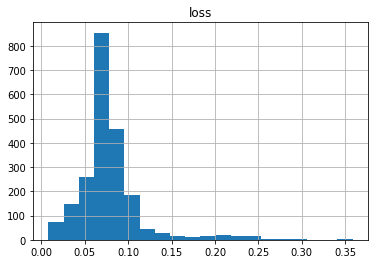

In [131]:
gene_loss=cellDancer_df[['gene_name','loss']].drop_duplicates()


In [132]:
gene_list=['Klf7', 'Syt11', 'Gnao1', 'Dctn3', 'Gpm6b', 'Stxbp6', 'Dcx', 'Psd3', 'Ntrk2', 'Ncald', 'Slc1a3', 'Astn1', 'Camk2a', 'Evl','Tbc1d16', 'Cadm1', 'Kcnip1', 'Ptpro', 'Sez6l', 'Diaph3',]

<AxesSubplot:ylabel='Frequency'>

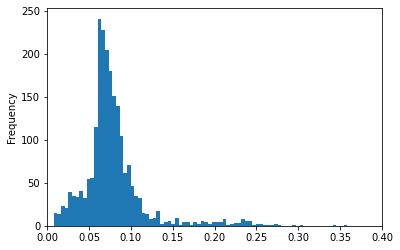

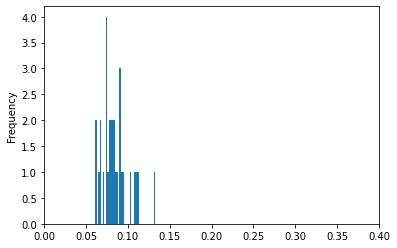

In [164]:
gene_loss_20genes=gene_loss[gene_loss.gene_name.isin(gene_list)]
plt.figure()
gene_loss['loss'].plot.hist(xlim=(0,0.4),bins=80)
plt.figure()
gene_loss_20genes['loss'].plot.hist(xlim=(0,0.4),bins=40)

<AxesSubplot:title={'center':'hist loss'}, ylabel='Density'>

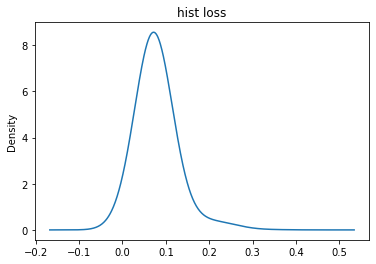

In [152]:
fig, ax = plt.subplots()
gene_loss.loss.plot.kde(ax=ax, legend=False, title='hist loss',bw_method=1)


In [145]:
gene_loss_20genes.sort_values('loss')

,gene_name,loss
30674740,Syt11,0.060929
32996660,Cadm1,0.064899
4408020,Dctn3,0.066869
6385280,Dcx,0.073448
17940460,Evl,0.074870
671180,Klf7,0.077477
2739140,Gnao1,0.078081
38783320,Kcnip1,0.079982
19409800,Ncald,0.081272
37187000,Sez6l,0.082143


cellDancer_df## Compute Cell Velocity

In [155]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,Stom,0.000000,0.006305,9.385150e-07,0.006294,0.000002,0.951817,0.003524,0.068943,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429,0,NaN,NaN
1,1,Stom,0.000000,0.006305,9.385150e-07,0.006294,0.000002,0.951817,0.003524,0.068943,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895,1,NaN,NaN
2,2,Stom,0.000000,0.008353,9.295276e-07,0.008339,0.000002,0.951943,0.003514,0.068943,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419,2,NaN,NaN
3,3,Stom,0.000000,0.000000,9.668082e-07,0.000000,0.000002,0.951425,0.003555,0.068943,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485,3,NaN,NaN
4,4,Stom,0.000000,0.000000,9.668082e-07,0.000000,0.000002,0.951425,0.003555,0.068943,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39109835,18135,Prmt8,0.131071,0.262922,1.410238e-01,0.266331,0.095084,0.573575,0.260010,0.109623,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668,18135,NaN,NaN
39109836,18136,Prmt8,0.198949,0.531809,2.013258e-01,0.517340,0.117767,0.568054,0.266923,0.109623,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788,18136,NaN,NaN
39109837,18137,Prmt8,0.173362,0.212177,1.804222e-01,0.234265,0.112805,0.569238,0.256904,0.109623,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364,18137,NaN,NaN
39109838,18138,Prmt8,0.216978,0.338159,2.186953e-01,0.355581,0.126118,0.565421,0.259761,0.109623,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549,18138,NaN,NaN


## Coumpute and visualize the prediction in embedding level

The prediction in the embedding level could be calculated with ```celldancer.compute_cell_velocity.compute()```. If not specified, all genes in cellDancer_df will be used to calculate the prediction in the embedding level. Following the method of [velocyto](link) and [scVelo](link), we project the velocity vectors of the cells into the low-dimensional embedding space. The probabilities of one cell transitioning into another cell are computed.

After the calculation, the predicted direction in the embedding level, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```cdplt.cell.scatter_cell()``` could be used to display the predicted direction in embedding level.

(genes, cells): (2156, 18140)


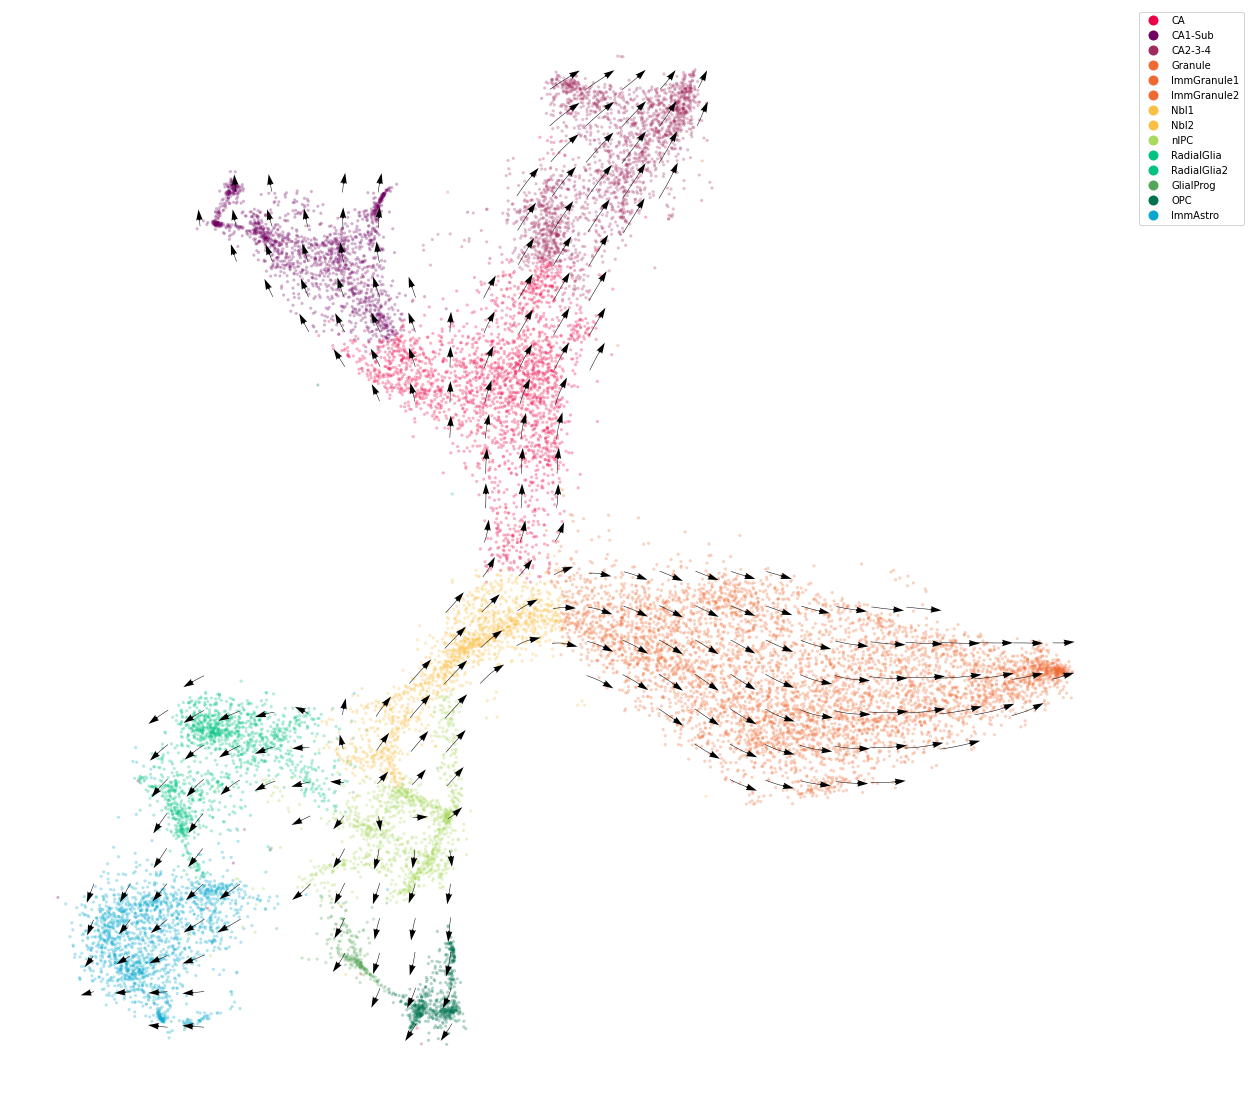

In [11]:
%autoreload 2

# Compute cell velocity
cellDancer_df=cd.compute_cell_velocity.compute(cellDancer_df=cellDancer_df)

# Plot cell velocity
fig, ax = plt.subplots(figsize=(20,20))
im = cdplt.cell.scatter_cell(ax,cellDancer_df, colors=colormap.colormap_neuro, alpha=0.3, s=10,
             velocity=True, legend='on',min_mass=2,arrow_grid=(30,30))
ax.axis('off')
plt.show()

## Estimate pseudotime

Based on the prediction in embedding level, the pseudotime could be estimated with ```cd.pseudo_time.pseudo_time()```

In [16]:
%%capture
%autoreload 2

# Set parameters
dt = 0.001
t_total = {0.001: 10000}
n_repeats = 10
speed_up=(60,60)
grid = (30, 30)

cellDancer_df = cd.pseudo_time.pseudo_time(cellDancer_df=cellDancer_df, 
                                          grid=grid, 
                                          dt=dt, 
                                          t_total=t_total[dt],
                                          n_repeats=n_repeats,
                                          speed_up=speed_up,
                                          n_paths = 5,
                                          psrng_seeds_diffusion=[i for i in range(n_repeats)],
                                          activate_umap_paths_divider=False,
                                          n_jobs=8)

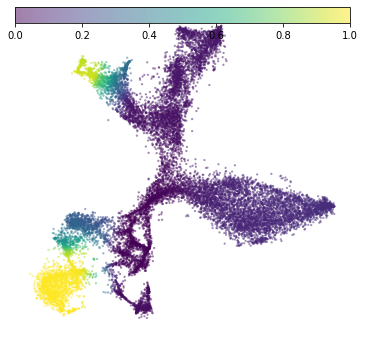

In [17]:
# Plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, velocity=False)
ax.axis('off')
plt.show()

### Pseudotime of gene

Let’s visualize the spliced RNA abundance of some sample genes based on pseudotime with ```celldancer.cdplt.gene.scatter_gene()```.

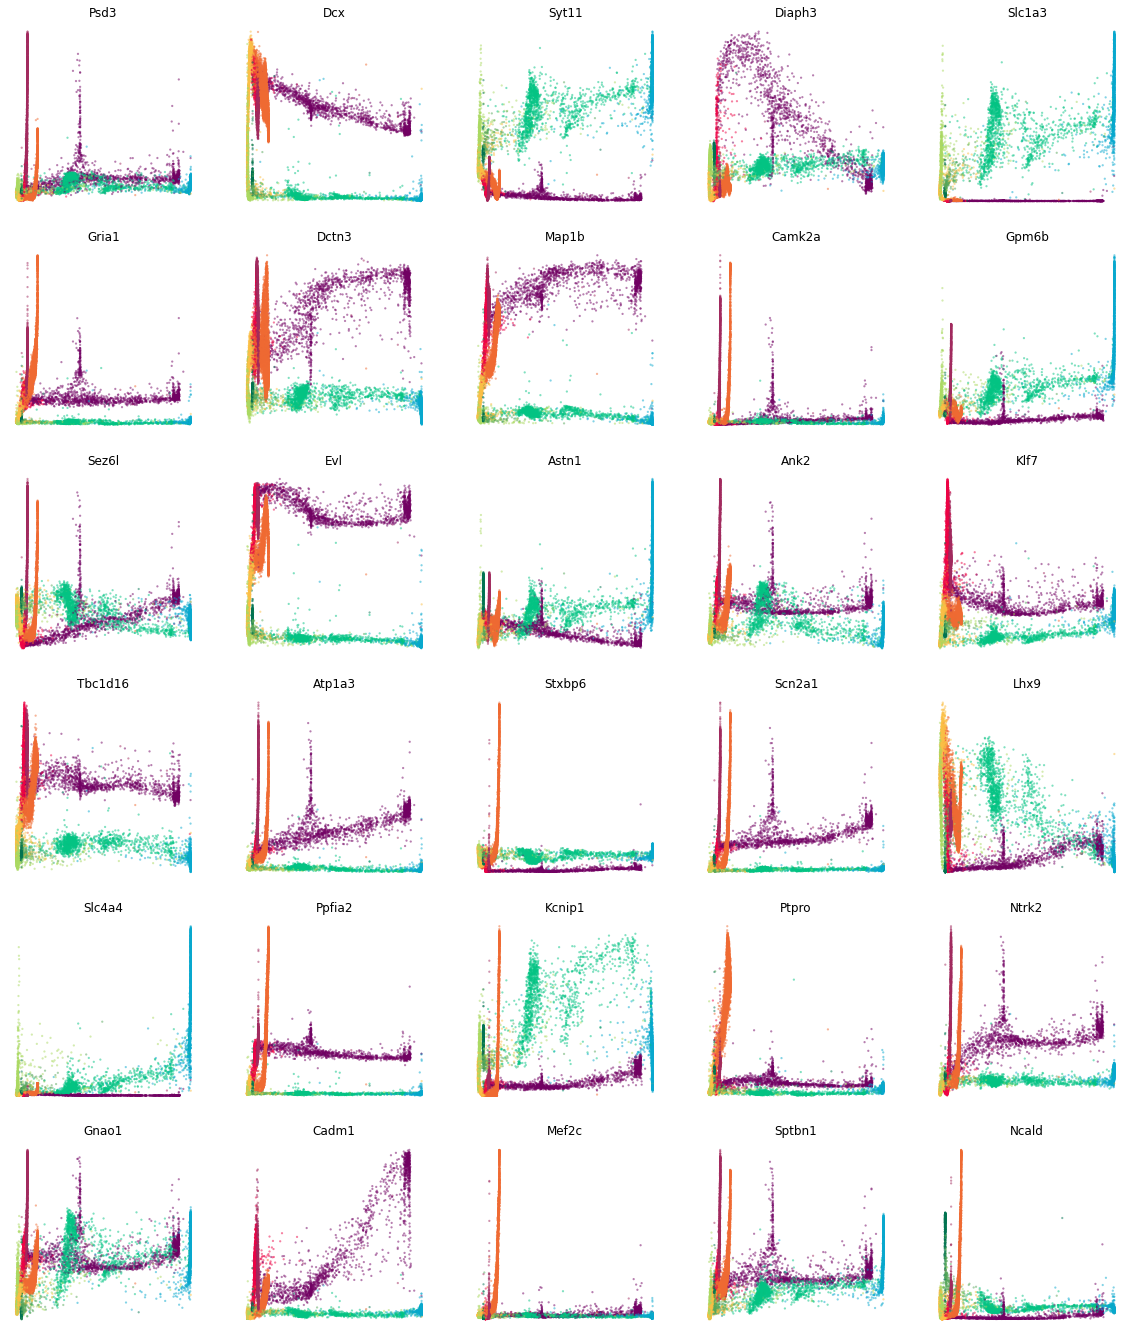

In [18]:
ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_neuro,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

## Gene Parameter in Cell Level

#

In [28]:
ax

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

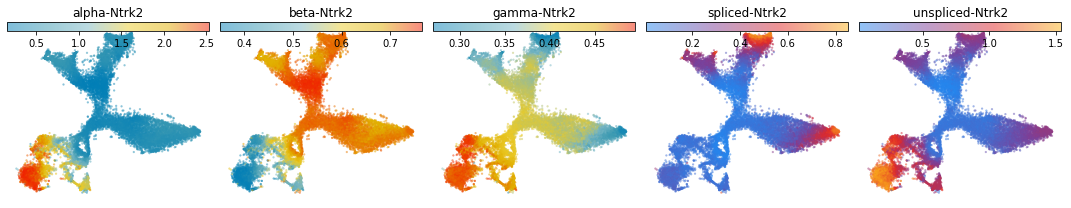

In [32]:
gene_samples=['Ntrk2','Psd3','Elavl4','Rimbp2'][0:1]

for gene in gene_samples:
    fig, ax = plt.subplots(ncols=5, figsize=(15,3))
    cdplt.cell.scatter_cell(ax[0],cellDancer_df, colors='alpha', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[1],cellDancer_df, colors='beta', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[2],cellDancer_df, colors='gamma', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[3],cellDancer_df, colors='splice', 
                 gene=gene, velocity=False)
    cdplt.cell.scatter_cell(ax[4],cellDancer_df, colors='unsplice', 
                 gene=gene, velocity=False)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[4].axis('off')
    ax[0].set_title('alpha-'+gene)
    ax[1].set_title('beta-'+gene)
    ax[2].set_title('gamma-'+gene)
    ax[3].set_title('spliced-'+gene)
    ax[4].set_title('unspliced-'+gene)
    plt.tight_layout()
    plt.show()

## UMAP using alpha, beta, and gamma

In [31]:
cellDancer_df=embedding(cellDancer_df,'alpha')
cellDancer_df=embedding(cellDancer_df,'beta')
cellDancer_df=embedding(cellDancer_df,'gamma')
cellDancer_df=embedding(cellDancer_df,'alpha_beta_gamma')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


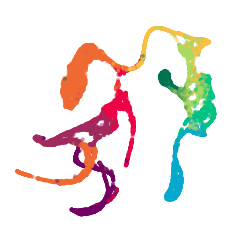

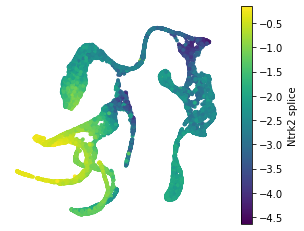

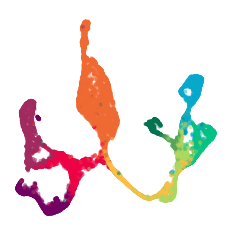

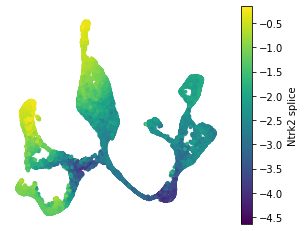

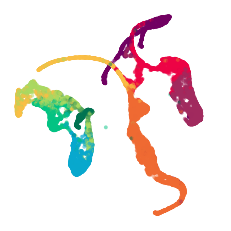

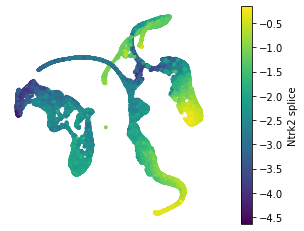

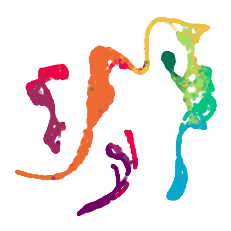

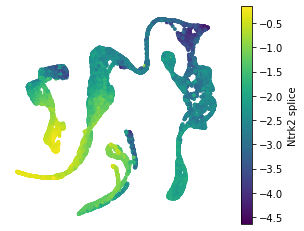

In [35]:
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,color_map=cdplt.colormap.colormap_neuro, save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('beta',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)
cdplt.cell.plot_kinetic_para('alpha_beta_gamma',cellDancer_df,gene='Ntrk2',color_map=cdplt.colormap.colormap_neuro ,save_path=None,title=None)